# 0. Title & Overview

Consumer-to-Shop Fashion Retrieval Demo

**Final Model**
- Backbone: EfficientNet-B3
- Loss: Batch-Hard Triplet Loss
- Margin: 0.1
- Embedding Dim: 256

# 1. Environment & Reproducibility

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Basic imports
import torch, random, os, sys
import shutil
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import matplotlib.pyplot as plt
from PIL import Image

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

# Seed
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed(42)

Mounted at /content/drive
Using device: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#2.  Path & Final Config

In [ ]:
FINAL_MARGIN = 0.1
BATCH_SIZE = 32
PATIENCE = 5
NUM_WORKERS = 4

In [ ]:
MODULE_PATH = "/content/drive/MyDrive/2025CV"
CSV_PATH = os.path.join(MODULE_PATH, "meta_c2s_10_2_2_sampling_ID.csv")
DRIVE_IMG_ROOT = os.path.join(MODULE_PATH, "Images") #원본 이미지
LOCAL_IMG_ROOT = "/content/Images" #로컬 타겟

df = pd.read_csv(CSV_PATH)

In [ ]:
# test split만 필터링
test_df = df[df["split"] == "test"]

# 필요한 이미지 경로(consumer + shop)
required_paths = pd.concat([
    test_df["consumer_path"],
    test_df["shop_path"]
]).dropna().unique()

print(f"총 {len(required_paths)}개 이미지 복사 시작 (test split만)")

os.makedirs(LOCAL_IMG_ROOT, exist_ok=True)
copied = 0

for rel_path in tqdm(required_paths, desc="Copying test images", unit="img"):
    src = os.path.join(DRIVE_IMG_ROOT, rel_path)
    dst = os.path.join(LOCAL_IMG_ROOT, rel_path)

    os.makedirs(os.path.dirname(dst), exist_ok=True)

    if os.path.exists(src) and not os.path.exists(dst):
        shutil.copy2(src, dst)
        copied += 1

print(f"✅ 복사 완료: {copied}개 (test split only)")

총 757개 이미지 복사 시작 (test split만)


Copying test images: 100%|██████████| 757/757 [11:32<00:00,  1.09img/s]

✅ 복사 완료: 757개 (test split only)


#3. Dataset & Transform



In [ ]:
sys.path.append(MODULE_PATH)

In [ ]:
from dataset_inference import DeepFashionC2S
from transforms import train_transform, val_transform
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
IMG_ROOT = LOCAL_IMG_ROOT

#None을 반환하는 샘플(파일 누락)을 필터링하고 collate
def custom_collate_fn(batch):
    batch = [item for item in batch if item is not None]
    if len(batch) == 0:
        return None

    return default_collate(batch)

#test dataset 준비
#When training in CPU
PIN_MEMORY = torch.cuda.is_available()

test_ds = DeepFashionC2S(
    csv_path=CSV_PATH,
    img_root=IMG_ROOT,
    transform=val_transform,
    split="test",
)

test_dl = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    collate_fn=custom_collate_fn
)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# 4. Model Definition (Feature Embedding)

In [ ]:
class FeatureEmbedding(nn.Module):
    def __init__(self):
        super().__init__()

        base_model = models.efficientnet_b3(
            weights=models.EfficientNet_B3_Weights.IMAGENET1K_V1
        )
        num_ftrs = base_model.classifier[1].in_features

        self.feature_extractor = base_model.features
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.final_fc = nn.Linear(num_ftrs, 256)

        self.bn = nn.BatchNorm1d(256)

    def forward(self, x):
        x = self.feature_extractor(x)
        if hasattr(self, 'avgpool'):
            x = self.avgpool(x)

        x = x.view(x.size(0), -1)
        x = self.final_fc(x)
        x = self.bn(x)
        x = F.normalize(x, p=2, dim=1)
        return x.to(DEVICE)

In [ ]:
model = FeatureEmbedding().to(DEVICE)

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth


100%|██████████| 47.2M/47.2M [00:00<00:00, 114MB/s]


# 5. Load Checkpoint


In [ ]:
best_ckpt_path = os.path.join(MODULE_PATH, "checkpoint.pth")

if os.path.exists(best_ckpt_path):
    checkpoint = torch.load(best_ckpt_path, map_location=DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"✅ Loaded best checkpoint from: {best_ckpt_path}")
else:
    print(f"⚠️ Checkpoint not found: {best_ckpt_path}")

✅ Loaded best checkpoint from: /content/drive/MyDrive/2025CV/checkpoint.pth


# 6. **Demo: Consumer → Top-K Shop Retrieval**

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def run_demo(dataset, model, idx, img_root, k=5, batch_size=32):
    """
    dataset[idx]의 consumer 이미지를 query로 사용하여
    dataset 내 모든 shop 이미지 중 유사한 Top-K를 찾고 시각화까지 수행.
    """
    model.eval()
    sample = dataset[idx]
    query_path = dataset.df.iloc[idx]["consumer_path"]
    print(f"\nQuery: {query_path}")

    query = sample["consumer"].unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        q_emb = model(query).cpu()

    gallery_embs = []
    shop_paths = []

    # gallery embedding 계산 (batch 단위)
    for i in range(0, len(dataset), batch_size):
        batch, batch_paths = [], []
        for j in range(i, min(i + batch_size, len(dataset))):
            d = dataset[j]
            if d is None:
                continue
            batch.append(d["shop"])
            batch_paths.append(dataset.df.iloc[j]["shop_path"])
        if not batch:
            continue

        batch = torch.stack(batch).to(DEVICE)
        with torch.no_grad():
            emb = model(batch).cpu()
        gallery_embs.append(emb)
        shop_paths.extend(batch_paths)

        del batch, emb
        torch.cuda.empty_cache()

    # similarity 계산
    gallery_embs = torch.cat(gallery_embs, dim=0)
    sims = torch.matmul(q_emb, gallery_embs.T).numpy()[0]

    # 중복 제거 후 상위 K개 선택
    ranked = np.argsort(-sims)
    seen = set()
    unique_topk = []
    for ridx in ranked:
        path = shop_paths[ridx]
        if path not in seen:
            seen.add(path)
            unique_topk.append(ridx)
        if len(unique_topk) >= k:
            break

    print("\nTop-K unique shop paths:")
    for i, rank in enumerate(unique_topk):
        print(f"Top-{i+1}: {shop_paths[rank]} (sim={sims[rank]:.4f})")

    # 시각화
    plt.figure(figsize=(15, 4))

    # Query 이미지
    plt.subplot(1, len(unique_topk) + 1, 1)
    plt.imshow(Image.open(os.path.join(img_root, query_path)))
    plt.title("Query (Consumer)")
    plt.axis("off")

    # Top-K 결과 이미지들
    for i, rank in enumerate(unique_topk):
        shop_path = os.path.join(img_root, shop_paths[rank])
        plt.subplot(1, len(unique_topk) + 1, i + 2)
        plt.imshow(Image.open(shop_path))
        plt.title(f"Top-{i+1}")
        plt.axis("off")

    plt.show()

    return unique_topk

## Pick consumer image in testset and show results


===== [1/5] Running demo for idx=155 =====

Query: img/TOPS/Summer_Wear/id_00027981/consumer_01.jpg

Top-K unique shop paths:
Top-1: img/TOPS/Summer_Wear/id_00027981/shop_01.jpg (sim=0.5716)
Top-2: img/TOPS/Summer_Wear/id_00029049/shop_02.jpg (sim=0.4257)
Top-3: img/TOPS/Summer_Wear/id_00031136/shop_01.jpg (sim=0.4023)
Top-4: img/TOPS/Summer_Wear/id_00029842/shop_01.jpg (sim=0.3660)
Top-5: img/TOPS/Summer_Wear/id_00031136/shop_02.jpg (sim=0.3313)


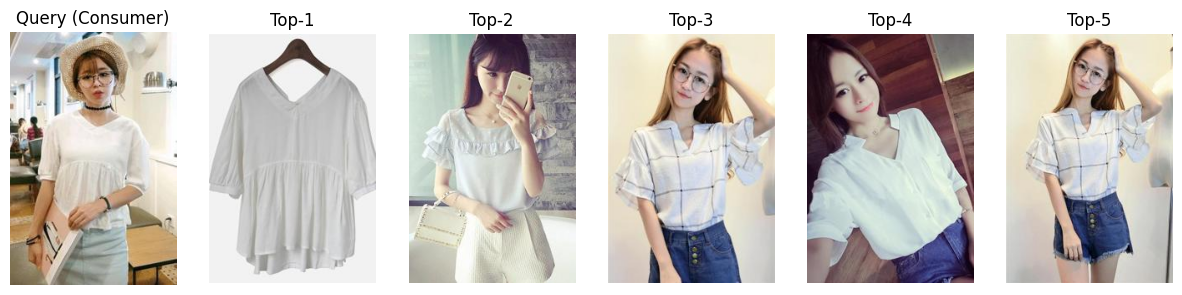


===== [2/5] Running demo for idx=288 =====

Query: img/TOPS/Summer_Wear/id_00009451/consumer_05.jpg

Top-K unique shop paths:
Top-1: img/TOPS/Summer_Wear/id_00009451/shop_02.jpg (sim=0.7003)
Top-2: img/TOPS/Summer_Wear/id_00009451/shop_01.jpg (sim=0.4223)
Top-3: img/TOPS/T_Shirt/id_00021659/shop_01.jpg (sim=0.3614)
Top-4: img/TOPS/Summer_Wear/id_00009451/shop_03.jpg (sim=0.3322)
Top-5: img/TOPS/Summer_Wear/id_00009396/shop_02.jpg (sim=0.3206)


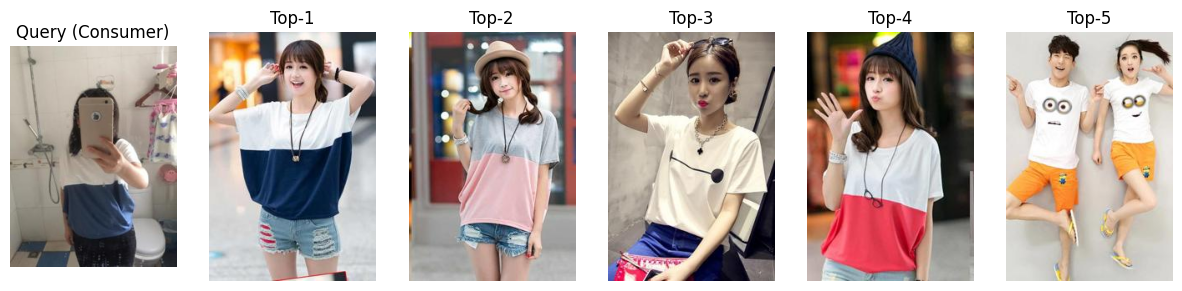


===== [3/5] Running demo for idx=449 =====

Query: img/TOPS/Summer_Wear/id_00031556/consumer_01.jpg

Top-K unique shop paths:
Top-1: img/TOPS/Tank_Top/id_00031556/shop_02.jpg (sim=0.9195)
Top-2: img/TOPS/Tank_Top/id_00031556/shop_01.jpg (sim=0.4953)
Top-3: img/TOPS/Summer_Wear/id_00009396/shop_01.jpg (sim=0.2676)
Top-4: img/TOPS/Summer_Wear/id_00009396/shop_02.jpg (sim=0.2618)
Top-5: img/TOPS/Tank_Top/id_00026382/shop_02.jpg (sim=0.2239)


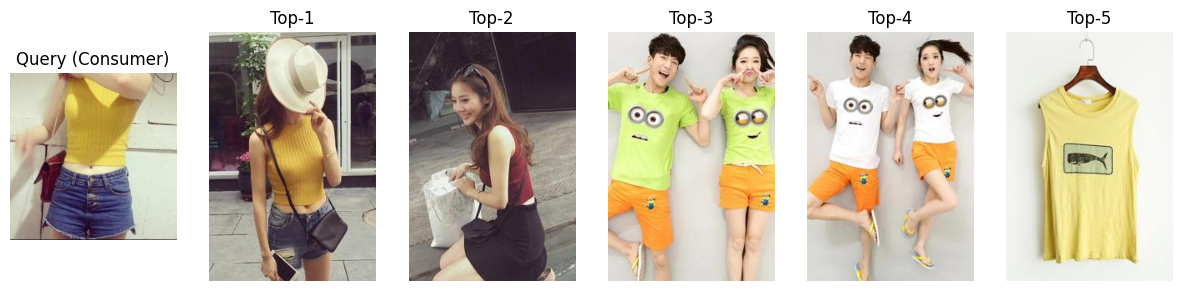


===== [4/5] Running demo for idx=604 =====

Query: img/TOPS/Lace_Shirt/id_00025743/consumer_01.jpg

Top-K unique shop paths:
Top-1: img/TOPS/Lace_Shirt/id_00025743/shop_01.jpg (sim=0.5745)
Top-2: img/TOPS/Summer_Wear/id_00029049/shop_02.jpg (sim=0.5236)
Top-3: img/TOPS/Summer_Wear/id_00029049/shop_01.jpg (sim=0.4480)
Top-4: img/DRESSES/Dress/id_00023791/shop_01.jpg (sim=0.3418)
Top-5: img/TOPS/Blouse/id_00010960/shop_01.jpg (sim=0.2383)


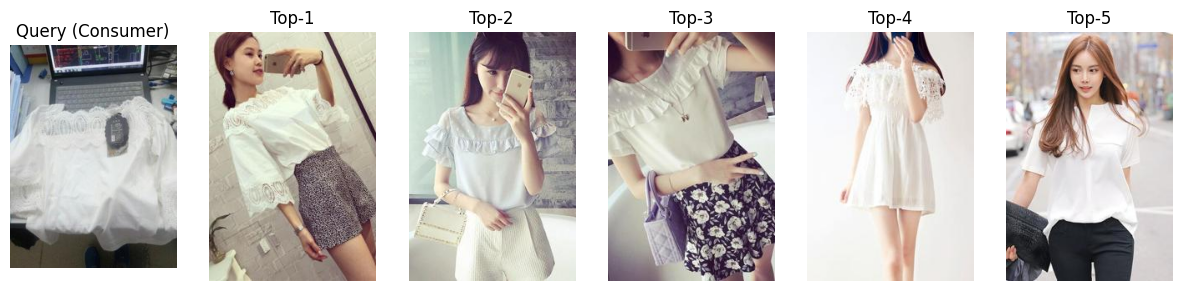


===== [5/5] Running demo for idx=902 =====

Query: img/DRESSES/Dress/id_00008175/consumer_01.jpg

Top-K unique shop paths:
Top-1: img/DRESSES/Dress/id_00008175/shop_01.jpg (sim=0.6954)
Top-2: img/DRESSES/Dress/id_00008175/shop_02.jpg (sim=0.6363)
Top-3: img/TOPS/T_Shirt/id_00008306/shop_01.jpg (sim=0.4904)
Top-4: img/TOPS/Summer_Wear/id_00007478/shop_01.jpg (sim=0.3989)
Top-5: img/TOPS/Summer_Wear/id_00005352/shop_01.jpg (sim=0.3777)


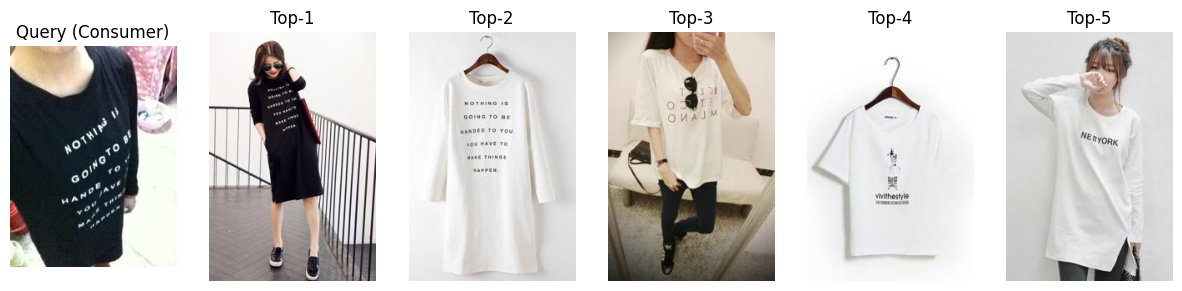

In [ ]:
query_idx_list = [155, 288, 449, 604, 902]

for i, idx in enumerate(query_idx_list):
    print(f"\n===== [{i+1}/{len(query_idx_list)}] Running demo for idx={idx} =====")

    run_demo(
        dataset=test_ds,
        model=model,
        idx=idx,
        img_root=IMG_ROOT,
        k=5
    )